In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
try:
    from imutils import paths
except ImportError:
    !pip install imutils
    from imutils import paths
    
import matplotlib.pyplot as plt
%matplotlib inline

Lets start by analyzing the number of images in each class for the training set

In [4]:
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

5027
5015


### 1. Explanatory Analysis
Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

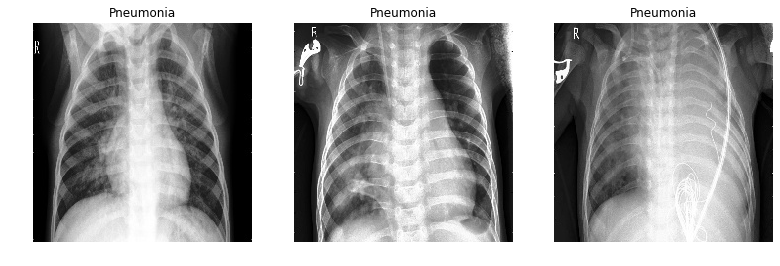

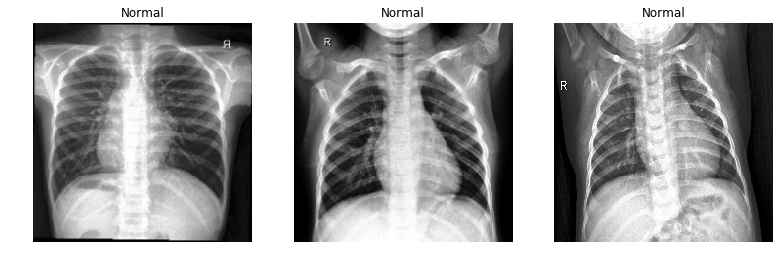

In [11]:
# function to read images
def read_image(im_path, rgb=True):
    im = cv2.imread(im_path)
    if rgb:
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

# define classes
columns = 3
classes = {
    "Pneumonia":[read_image(img) for img in random.sample(pneumonia_train, columns)], 
    "Normal": [read_image(img) for img in random.sample(normal_train, columns)]
}
# this method displays images for two classes based adjacent to each other
def display(classes, columns, read_as_rgb=True, cmap=None):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(11, 11), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img, cmap=cmap)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

Let us do some preprocessing that will bring up the contrast in the images. The approach is,

-> RGB -> HSV -> H, S, V -> H, S, HistogramEqulize(V) -> HSV -> RGB

In [12]:
def preprocess(image, input_mode="rgb"):
    img = image
    img = img.astype(np.uint8)
    if input_mode == "bgr":
        # BGR to HSV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    else:
        # RGB to HSV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # split to H,S,V
    H, S, V = cv2.split(img)
    # histogram equalize
    V = cv2.equalizeHist(V)
    # join back
    img = cv2.merge([H, S, V])
    # HSV to RGB
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    # RGB to GRAY
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

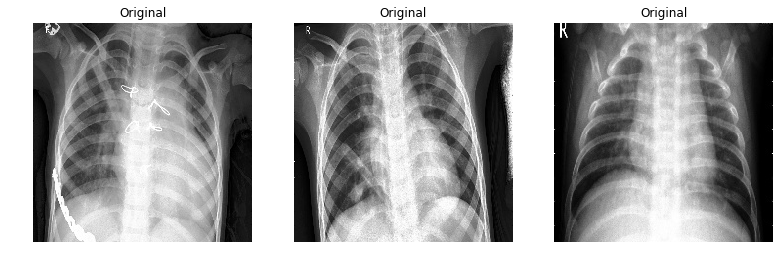

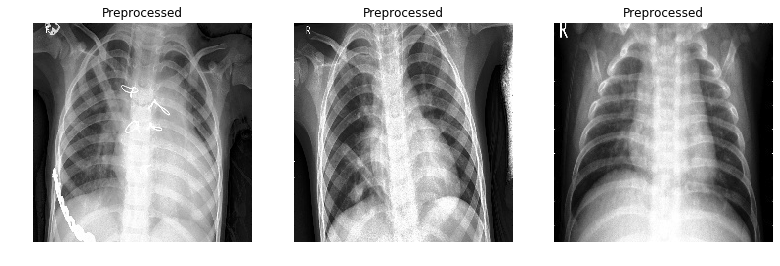

In [13]:
# get some random positive images
sample_positive = random.sample(pneumonia_train, 3)

# make a dictionary regular samples and preprocessed ones
classes = {
    "Original": [read_image(img) for img in sample_positive],
    "Preprocessed": [preprocess(read_image(img, rgb=False), input_mode="bgr") for img in sample_positive]
}

# display the images 
display(classes, 3, cmap="gray")

### 2. Data Preprocessing and Augumentation

In this section we will generate and standardize data to address class imbalance problem

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths

_generator = ImageDataGenerator(
    width_shift_range=0.001,
    height_shift_range=0.001,
    zoom_range=0.01,
    horizontal_flip=True,
    rotation_range=0.99
)

In [15]:
def load_images(directory):
    image_paths = list(paths.list_images(directory))
    images = []
    for i, im_path in enumerate(image_paths):
        # read 
        image = cv2.imread(im_path)
        # bgr2rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # resize
        image = cv2.resize(image, (256, 256))
        # append
        images.append(image)
    _images = [img_to_array(image, data_format="channels_last") for image in images]
    _images = np.array(_images)
    #_images = _images.astype(np.uint8)
    return _images

In [21]:
X_normal  = load_images(directory=os.path.join(os.getcwd(), "chest_xray/train/NORMAL/"))

In [22]:
X_normal_aug = _generator.flow(
    x=X_normal,
    y=None,
    batch_size=32,
    save_to_dir="chest_xray/train/NORMAL/",
    save_format="jpeg",
    save_prefix="augumented"
)
for i in range(int(np.ceil((5000 - X_normal.shape[0])/32))):
    x_normal = next(X_normal_aug)

In [23]:
# now also augument the Pneumonia class images
X_pneumonia = load_images(directory=os.path.join(os.getcwd(), "chest_xray/train/PNEUMONIA/"))

In [24]:
X_pneumonia_aug = _generator.flow(
    x=X_pneumonia,
    y=None,
    batch_size=32,
    save_to_dir="chest_xray/train/PNEUMONIA/",
    save_format="jpeg",
    save_prefix="augumented"
)
for i in range(int(np.ceil((5000 - X_pneumonia.shape[0])/32))):
    x_pneumonia = next(X_pneumonia_aug)

Define the generators required for Training and Validation 

In [16]:
IM_WIDTH = 224
IM_HEIGHT = 224
BATCH_SIZE = 32

In [14]:

# we will read all images in the train, val, and test prprocess them and save them to disk to avoid slow training time (GPU partial utilization)
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))

pneumonia_val = list(paths.list_images("chest_xray/val/PNEUMONIA/"))
normal_val = list(paths.list_images("chest_xray/val/NORMAL/"))

pneumonia_test = list(paths.list_images("chest_xray/test/PNEUMONIA/"))
normal_test = list(paths.list_images("chest_xray/test/NORMAL/"))


# for each directory
for i, directory in enumerate([pneumonia_train, normal_train, pneumonia_val, normal_val, pneumonia_test, normal_test]):
    
    print("Preprocessing images for {}".format(str(i)))
    # for each image
    for path in directory:
        # read the image
        image = cv2.imread(path)
        image = preprocess(image, input_mode="bgr")
        image = cv2.resize(image, (IM_HEIGHT, IM_WIDTH))
        cv2.imwrite(path, image)

Preprocessing images for 0
Preprocessing images for 1
Preprocessing images for 2
Preprocessing images for 3
Preprocessing images for 4
Preprocessing images for 5


In [18]:

COLOR_MODE = "rgb"

def _preprocess(image, input_mode="rgb"):
    img = image
    img = img.astype(np.uint8)
    if input_mode == "bgr":
        # BGR to HSV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    else:
        # RGB to HSV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # split to H,S,V
    H, S, V = cv2.split(img)
    # histogram equalize
    V = cv2.equalizeHist(V)
    # join back
    img = cv2.merge([H, S, V])
    # HSV to RGB
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    # RGB to GRAY
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # you'll be banging your head against the wall without this line
    img = img_to_array(img, data_format="channels_last")
    
    return img

# generator for train and validation
_image_generator = ImageDataGenerator(
    rescale=1./255
)

# train
_train = _image_generator.flow_from_directory(
    directory="chest_xray/train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)


# validation
_valid = _image_generator.flow_from_directory(
    directory="chest_xray/val/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=16
)

# new one
_new_validation = _image_generator.flow_from_directory(
    directory="chest_xray/train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)

Found 10042 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


### Model Definition and Training

Let us construct a CNN and train with above data

In [28]:
import numpy as np
np.random.seed(255)
import os
os.environ["PYTHONHASHSEED"] = str(255)
import random
random.seed(255)
import tensorflow as tf
tf.set_random_seed(255)

from keras import backend as K
tf_config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=tf_config)
K.set_session(sess)

from keras import callbacks
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

In [82]:
class CustomNet(object):

    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling
    
    def model(self):
        input_shape = (self.height, self.width, self.channels)
        chan_dim = -1
        # initiate model
        model = Sequential()
        
        # 224x224
        # conv 1
        model.add(Conv2D(self.scale, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 2
        model.add(Conv2D(self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 1
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        
        # 112x112
        # conv 3
        model.add(Conv2D(2*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 4
        model.add(Conv2D(2*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 2
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        # 56x56
        # conv 5
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 6
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 7
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 3
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))
        # 28x28

        # fully connected 
        model.add(Flatten())
        # fc 1
        model.add(Dense(512))
        model.add(Activation("relu"))
        #model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 2
        model.add(Dense(1024))
        model.add(Activation("relu"))
        #model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(self.output_classes, activation="softmax"))
        
        # print(model.summary())
        # return 
        return model

In [101]:
LR = (1e-4)
SCALE = 10
BATCH_SIZE = 64
EPOCHS = 25

def lr_scheduler(epoch, lr):
    """
    if 20 <= epoch <= 35:
        return (1e-4)*0.25
    
    elif epoch > 40:
        return (1e-4)*0.1
    """
    if epoch >=20:
        return (1e-4)*0.1
    else:
        return lr
    
# define callbacks
_callbacks = [
    callbacks.TensorBoard(
        log_dir="tensorboard",
        write_graph=True,
        write_images=False    
    ),
    LearningRateScheduler(lr_scheduler)
]

# initiate model
model = CustomNet(
    height=IM_HEIGHT, 
    width=IM_WIDTH, 
    channels=3, 
    classes=2, 
    parameter_scaling=SCALE
).model()

# compile
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=LR),
    metrics=["accuracy"]
)

In [103]:
! rm -rf tensorboard/
! rm -rf .ipynb_checkpoints/

# train on default gpu
with tf.device("/gpu:0"):
    
    # start training
    history = model.fit_generator(
        generator=_train,
        steps_per_epoch=_train.samples//BATCH_SIZE,
        validation_data=_valid,
        validation_steps=_valid.samples,
        callbacks=_callbacks,
        epochs=EPOCHS
    )

Epoch 1/25
156/156 [==============================] - 26s 164ms/step - loss: 0.2376 - acc: 0.9099 - val_loss: 0.1405 - val_acc: 0.8750
Epoch 2/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1938 - acc: 0.9311 - val_loss: 0.2549 - val_acc: 0.8125
Epoch 3/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1775 - acc: 0.9345 - val_loss: 0.1115 - val_acc: 0.9375
Epoch 4/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1654 - acc: 0.9419 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 5/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1410 - acc: 0.9469 - val_loss: 0.0891 - val_acc: 1.0000
Epoch 6/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1222 - acc: 0.9579 - val_loss: 0.0953 - val_acc: 0.9375
Epoch 7/25
156/156 [==============================] - 26s 164ms/step - loss: 0.1209 - acc: 0.9571 - val_loss: 0.1436 - val_acc: 0.9375
Epoch 8/25
156/156 [==============================] - 2

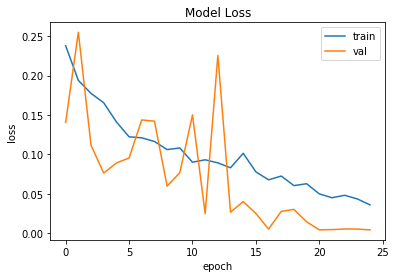

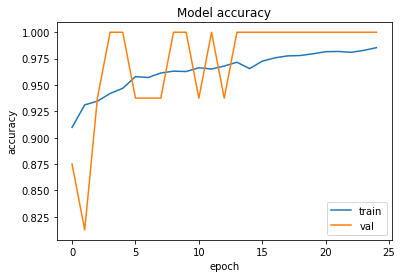

In [104]:
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [105]:
# test data
# validation
_test = _image_generator.flow_from_directory(
    directory="chest_xray/test/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=False,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=1
)
print(_test.class_indices)

Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [106]:
test_loss, test_acc = model.evaluate_generator(_test, steps=_test.samples, verbose=1)

print('val_loss:', test_loss)
print('val_cat_acc:', test_acc)

624/624 [==============================] - 4s 7ms/step
val_loss: 1.135287412369203
val_cat_acc: 0.8237179487179487


In [107]:
# PREDICT
predictions = model.predict_generator(_test, steps=_test.samples, verbose=1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = _test.classes

624/624 [==============================] - 7s 11ms/step
(624, 2)


In [108]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.86      0.55      0.67       234
   PNEUMONIA       0.78      0.95      0.85       390

   micro avg       0.80      0.80      0.80       624
   macro avg       0.82      0.75      0.76       624
weighted avg       0.81      0.80      0.79       624



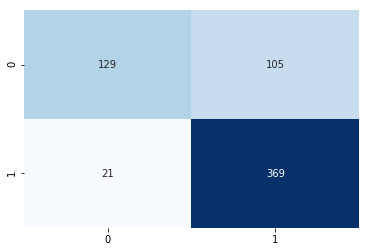

In [109]:
# heatmap
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt="d", 
    cbar = False, 
    cmap = plt.cm.Blues
)